In [71]:
import numpy as np
import torch
import torch.nn.functional as F #for one hot encoding
import pandas as pd
from matplotlib import pyplot as plt
import random

In [72]:
words=open("names.txt","r").read().splitlines()

In [4]:
len(words)

32033

In [125]:
chars = sorted(set(''.join(words)))  
chars =['.'] + chars     
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

27


In [6]:
block_size=3
X=[]
Y=[]
for w in words:
    #print(w)
    context=[0]*block_size
    for ch in w +'.':
        ix=stoi[ch]
        Y.append(ix)
        X.append(context)
        #print(''.join(itos[i] for i in context))
        context=context[1:]+[ix]
X=torch.tensor(X)
Y=torch.tensor(Y)

In [7]:
print(X[1])
print(Y[1])
print(X.shape)
print(Y.shape)

tensor([0, 0, 5])
tensor(13)
torch.Size([228146, 3])
torch.Size([228146])


In [19]:
# now we need to embed X for the neural network
C=torch.randn(27,2)
emb=C[X] #yeah we can just do this with pytorch
emb.shape

torch.Size([228146, 3, 2])

In [20]:
W1=torch.randn(6,100) #100 neurons for the first hidden layers
B1=torch.randn(100)

In [21]:
h=torch.tanh(emb.view(-1,6) @ W1 + B1)

In [23]:
h.shape

torch.Size([228146, 100])

In [26]:
W2=torch.randn(100,27)
B2=torch.randn(27)

In [43]:
logits=h @ W2 +B2
'''
count=logits.exp()
probs=count/count.sum(1,keepdim=True)
loss=-probs[torch.arange(len(Y)),Y].log().mean()
'''
loss=F.cross_entropy(logits,Y) 

tensor(15.1216)

In [236]:
# creating traing testing and validation dataset
def buildDataset(words):
    block_size=3
    X=[]
    Y=[]
    for w in words:
        #print(w)
        context=[0]*block_size
        for ch in w +'.':
            ix=stoi[ch]
            Y.append(ix)
            X.append(context)
            #print(''.join(itos[i] for i in context))
            context=context[1:]+[ix]
    X=torch.tensor(X)
    Y=torch.tensor(Y)
    return X,Y

random.shuffle(words)
n=int(0.8*len(words))
m=int(0.9*len(words))
Xtrain,Ytrain=buildDataset(words[:n])
XVal,YVal=buildDataset(words[n:m])
Xtest,Ytest=buildDataset(words[m:])

In [237]:
n_emb=10 #dimansionality of each character
n_n=300 #number of neurons
C=torch.randn(len(chars),n_emb) 
W1=torch.randn(n_emb*block_size,n_n) * (5/3) / ((n_emb*block_size)**0.5) #to prevent plateau region of tanh for h
#the above formula is given in the pytorch documentation for standard deviation of tanh 
B1=torch.randn(n_n) * 0.01
W2=torch.randn(n_n,len(chars)) * 0.01
B2=torch.randn(len(chars)) * 0

bngain=torch.ones(1,n_n)
bnbais=torch.zeros(1,n_n) #batch normalization parameters 
bnmean_running=torch.ones(1,n_n)
bnstd_running=torch.zeros(1,n_n)

parameters=[C,W1,W2,B1,B2,bngain,bnbais]

In [238]:
for p in parameters:
    p.requires_grad=True

In [239]:
stepi=[]
lossi=[]
lr=0.1
batch_size=60

In [240]:
for i in range(200000): 
    #minibatch
    ix=torch.randint(0,Xtrain.shape[0],(batch_size,)) 
    #forward pass
    emb=C[Xtrain[ix]]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat @ W1 + B1
    hpreact= bngain * (hpreact-hpreact.mean(0,keepdim=True))/(hpreact.std(0,keepdim=True)+0.00001) +bnbais # batch normalization
    with torch.no_grad():
        bnmean_running=(0.99*bnmean_running) + (0.01 * hpreact.mean(0,keepdim=True))
        bnstd_running=(0.99*bnstd_running) + (0.01 * hpreact.std(0,keepdim=True))
    h=torch.tanh(hpreact)
    logits=h @ W2 +B2
    loss=F.cross_entropy(logits,Ytrain[ix])
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    if i>150000: #step decay learning rate
        lr=0.01
    for p in parameters:
        p.data-=lr*p.grad
    stepi.append(i)
    lossi.append(loss.item())
print("training loss: ",loss.item())

training loss:  2.157837152481079


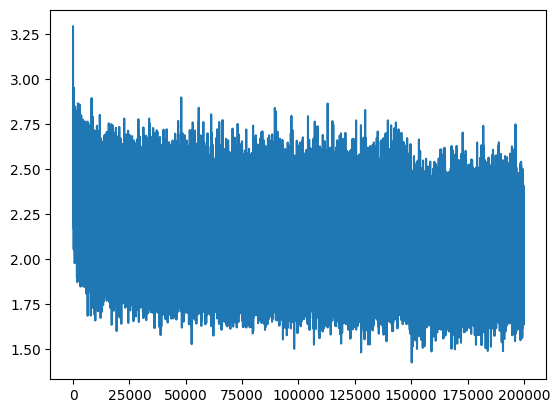

In [241]:
plt.plot(stepi,lossi)

(array([1519.,  740.,  501.,  451.,  393.,  384.,  335.,  315.,  284.,
         257.,  287.,  261.,  250.,  241.,  229.,  235.,  259.,  291.,
         296.,  239.,  299.,  245.,  252.,  259.,  243.,  241.,  300.,
         286.,  275.,  314.,  238.,  248.,  235.,  261.,  256.,  272.,
         282.,  252.,  274.,  259.,  267.,  253.,  266.,  360.,  316.,
         392.,  396.,  493.,  724., 1475.]),
 array([-9.99999940e-01, -9.60000029e-01, -9.20000117e-01, -8.80000205e-01,
        -8.40000293e-01, -8.00000381e-01, -7.60000470e-01, -7.20000558e-01,
        -6.80000646e-01, -6.40000734e-01, -6.00000823e-01, -5.60000911e-01,
        -5.20000999e-01, -4.80001087e-01, -4.40001175e-01, -4.00001264e-01,
        -3.60001352e-01, -3.20001440e-01, -2.80001528e-01, -2.40001616e-01,
        -2.00001705e-01, -1.60001793e-01, -1.20001881e-01, -8.00019693e-02,
        -4.00020576e-02, -2.14576721e-06,  3.99977660e-02,  7.99976778e-02,
         1.19997590e-01,  1.59997501e-01,  1.99997413e-01,  2.399973

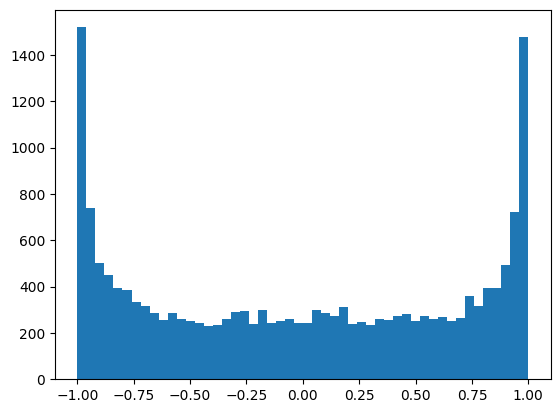

In [242]:
plt.hist(h.view(-1).tolist(),50)

In [243]:
emb=C[XVal]
embcat=emb.view(emb.shape[0],-1)
hpreact=embcat @ W1 + B1
hpreact= bngain * (hpreact-bnmean_running)/bnstd_running +bnbais # batch normalization
h=torch.tanh(hpreact)
logits=h @ W2 +B2
loss=F.cross_entropy(logits,YVal)
print("Validation loss: ",loss.item())

Validation loss:  3.2792587280273438


In [261]:
# for sampling
for _ in range(20):
    out=[]
    Context=[0]*block_size
    while True:
        emb=C[torch.tensor([Context])]
        h=torch.tanh(emb.view(-1,n_emb*block_size) @ W1 + B1)
        logits=h @ W2 +B2
        probs=F.softmax(logits,dim=1)
        ix=torch.multinomial(probs,num_samples=1).item() #choosing by probability
        out.append(ix)
        Context=Context[1:]+[ix]
        if ix==0:
            break
    print("".join(itos[i] for i in out))

zhammoorawfiheeddhliahnitygen.
cyzbix.
blu.
wlolichariusaffraytlixxkviyah.
ksophieffarwelzamyorazhu.
sarborterzeydlardis.
willyah.
leightoriagraqfatbordeviannalpwesmaebixatelfwynilignycharlizlynnlivarnesmanurtnatifidenyah.
vivigustevisiddyxxamilynn.
wyakingartishav.
wzormikzev.
rixliviyabfizinevvingjipvaidvikoliviebmoxznitzabdul.
duphaspilanghtorlyefiliah.
blaxxxyventemiusarsemmabiglaxcolyviacquvifkremmiolynd.
stvipher.
jepbellexxyoptatakhermanuolevertisukwozagdycrsheppespengsk.
chladdarickevishenziquinveilegty.
xdewynleyzleighavorylestallexxyorder.
bliamedguszen.
lyuxchakinbebigaelesslwestevys.


In [235]:
probs

tensor([[4.9804e-01, 8.8129e-02, 5.8360e-04, 5.5211e-03, 6.6098e-02, 7.5206e-03,
         2.4775e-03, 7.2080e-02, 2.9395e-02, 7.9708e-03, 4.8506e-03, 3.6921e-03,
         2.1477e-03, 7.7111e-04, 2.3217e-02, 1.4324e-03, 4.0449e-04, 4.3175e-04,
         1.3541e-01, 4.6595e-03, 2.2407e-02, 7.9302e-03, 4.0006e-03, 1.3557e-03,
         6.1095e-04, 5.9938e-03, 2.8694e-03]], grad_fn=<SoftmaxBackward0>)